# Memory-Aware Inference via LangGraph

Graph structure (from architecture diagram):
```
Persona A
  ├── belongs_to  →  Session Memory      (per year)
  ├── belongs_to  →  Latent Persuasion   (per year)
  ├── belongs_to  →  Strategy Memory     (per year)
  └── belongs_to  →  Concession Memory   (per year)
        ↕ temporal_next  (year → year+1)
        ↕ derived_from   (session → latent)
        ↕ similar_to     (cosine similarity across sessions)
```

**Allowed relations:** `temporal_next`, `derived_from`, `belongs_to`, `has_attribute`, `similar_to`

In [22]:
# ─── Cell 1: Imports & Constants ─────────────────────────────────────────────
import json
import os
import math
import pathlib
from typing import TypedDict, List, Dict, Any

from langgraph.graph import StateGraph
from IPython.display import display, Image

# ── Paths (robust for Jupyter — searches CWD and known absolute fallback) ──
_cwd = pathlib.Path.cwd()
if (_cwd / "memory").exists():
    INFERENCE_DIR = _cwd
else:
    INFERENCE_DIR = pathlib.Path("/DATA/rohan_kirti/niladri2/memory-agent/inference")

MEMORY_DIR = INFERENCE_DIR / "memory" / "personas"

# ── Graph hyper-params ──
TOP_K_SIMILAR  = 2   # sessions to fetch via cosine similarity
MAX_NODES      = 8   # token-budget cap in merge_rank

# ── Allowed graph relation labels (from diagram) ──
ALLOWED_RELATIONS = [
    "temporal_next",   # chronological progression
    "derived_from",    # provenance / computed from
    "belongs_to",      # persona ownership
    "has_attribute",   # entity/condition link
    "similar_to",      # semantic similarity
]

print("Imports OK.")
print(f"Memory dir : {MEMORY_DIR}")
print(f"Personas   : {[f.name for f in MEMORY_DIR.glob('*.json')]}")

Imports OK.
Memory dir : /DATA/rohan_kirti/niladri2/memory-agent/inference/memory/personas
Personas   : ['P_004.json', 'P_003.json', 'P_002.json', 'P_001.json']


In [23]:
# ─── Cell 2: MemoryState TypedDict ────────────────────────────────────────────
class MemoryState(TypedDict):
    persona_id:      str                  # e.g. "P_001"
    current_year:    int                  # year of the new conversation
    query_vector:    Dict[str, float]     # intent vector of incoming utterance
    retrieved_nodes: List[Dict[str, Any]] # accumulated graph nodes
    context:         str                  # final serialised output

print("MemoryState fields:", list(MemoryState.__annotations__.keys()))

MemoryState fields: ['persona_id', 'current_year', 'query_vector', 'retrieved_nodes', 'context']


In [24]:
# ─── Cell 3: Memory Loader & Helpers ──────────────────────────────────────────

def load_persona_memory(persona_id: str) -> dict:
    """Load full persona memory JSON."""
    path = MEMORY_DIR / f"{persona_id}.json"
    if not path.exists():
        raise FileNotFoundError(f"No memory file for persona {persona_id} at {path}")
    with open(path) as f:
        return json.load(f)


def cosine_similarity(a: Dict[str, float], b: Dict[str, float]) -> float:
    """Cosine similarity between two named-dimension vectors."""
    keys = set(a) & set(b)
    if not keys:
        return 0.0
    dot = sum(a[k] * b[k] for k in keys)
    na  = math.sqrt(sum(v ** 2 for v in a.values()))
    nb  = math.sqrt(sum(v ** 2 for v in b.values()))
    return dot / (na * nb + 1e-9)


def get_sorted_years(memory: dict) -> List[int]:
    """Return unique sorted years present in sessions."""
    return sorted(set(s["year"] for s in memory["sessions"]))


def get_sessions_by_year(memory: dict, year: int) -> List[dict]:
    return [s for s in memory["sessions"] if s["year"] == year]


def aggregate_sessions(sessions: List[dict]) -> dict:
    """Average multiple sessions for the same year; return single aggregated entry."""
    if len(sessions) == 1:
        return sessions[0]
    keys = list(sessions[0]["avg_intent_vector"].keys())
    avg_intent = {
        k: sum(s["avg_intent_vector"][k] for s in sessions) / len(sessions)
        for k in keys
    }
    merged = dict(sessions[-1])
    merged["avg_intent_vector"] = avg_intent
    return merged


# ── Quick sanity check ──
sample_mem = load_persona_memory("P_001")
print(f"P_001 years in memory: {get_sorted_years(sample_mem)}")
print(f"Strategies tracked   : {list(sample_mem.get('strategy_memory',{}).get('stats',{}).keys())}")
print(f"Latent keys          : {list(sample_mem.get('latent_state',{}).keys())}")

P_001 years in memory: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Strategies tracked   : ['Emotional', 'Logical', 'Credibility']
Latent keys          : ['trust', 'price_sensitivity', 'commitment', 'logical_resp', 'emotional_resp', 'credibility_resp', 'concession_expectation']


In [25]:
# ─── Cell 4: structural_recall_node  (belongs_to edges) ───────────────────────
#
# Always fetches the most recent memory entries for each memory type:
#   • Session Memory        (latest year's aggregated session)
#   • Latent Persuasion     (latent_state from the JSON)
#   • Strategy Memory       (strategy_memory.stats)
#   • Concession Memory     (concession_memory)

def structural_recall_node(state: MemoryState) -> MemoryState:
    print("\n[structural_recall_node] ─── belongs_to edges ───")
    memory      = load_persona_memory(state["persona_id"])
    years       = get_sorted_years(memory)
    latest_year = years[-1]

    nodes: List[Dict[str, Any]] = []

    # ── Session Memory (latest year) ──
    agg_session = aggregate_sessions(get_sessions_by_year(memory, latest_year))
    nodes.append({
        "node_type": "session",
        "year": latest_year,
        "edge": "belongs_to",
        "score": 1.0,
        "data": {
            "avg_intent_vector":   agg_session["avg_intent_vector"],
            "avg_strategy_vector": agg_session["avg_strategy_vector"],
            "final_outcome":       agg_session["final_outcome"],
            "trust_estimate":      agg_session["trust_estimate"],
            "price_sensitivity":   agg_session["price_sensitivity_estimate"],
        },
    })
    print(f"  [session]    year={latest_year}, outcome={agg_session['final_outcome']},"
          f" trust={agg_session['trust_estimate']:.3f}")

    # ── Latent Persuasion Memory ──
    latent = memory.get("latent_state", {})
    nodes.append({
        "node_type": "latent",
        "year": latest_year,
        "edge": "belongs_to",
        "score": 1.0,
        "data": latent,
    })
    print(f"  [latent]     trust={latent.get('trust', 0):.3f},"
          f" commitment={latent.get('commitment', 0):.3f},"
          f" concession_exp={latent.get('concession_expectation', 0):.3f}")

    # ── Strategy Memory ──
    strat_stats = memory.get("strategy_memory", {}).get("stats", {})
    # Compute success rate per strategy
    strat_summary = {
        k: {
            "success_rate": round(v["success_count"] / max(v["total_uses"], 1), 3),
            "total_uses":   v["total_uses"],
            "delta_readiness": round(v["total_delta_readiness"], 4),
        }
        for k, v in strat_stats.items()
    }
    nodes.append({
        "node_type": "strategy",
        "year": latest_year,
        "edge": "belongs_to",
        "score": 1.0,
        "data": strat_summary,
    })
    for strat, sv in strat_summary.items():
        print(f"  [strategy]   {strat}: success_rate={sv['success_rate']},"
              f" uses={sv['total_uses']}, delta_readiness={sv['delta_readiness']}")

    # ── Concession Memory ──
    conc = memory.get("concession_memory", {})
    conc_data = {
        "negotiation_graph":        conc.get("negotiation_graph", {}),
        "last_user_request":        conc.get("user_requests_history", [None])[-1],
        "last_agent_offer":         conc.get("agent_offers_history",  [None])[-1],
        "total_negotiation_rounds": len(conc.get("user_requests_history", [])),
    }
    nodes.append({
        "node_type": "concession",
        "year": latest_year,
        "edge": "belongs_to",
        "score": 1.0,
        "data": conc_data,
    })
    print(f"  [concession] last_user_req={conc_data['last_user_request']},"
          f" last_agent_offer={conc_data['last_agent_offer']},"
          f" rounds={conc_data['total_negotiation_rounds']}")

    state["retrieved_nodes"] = nodes
    return state

print("structural_recall_node defined.")

structural_recall_node defined.


In [26]:
# ─── Cell 5: semantic_session_node  (similar_to edges) ────────────────────────
#
# Computes cosine similarity between the incoming query_vector and every
# session's avg_intent_vector. Returns top-K sessions tagged similar_to.

def semantic_session_node(state: MemoryState) -> MemoryState:
    print("\n[semantic_session_node] ─── similar_to edges ───")
    memory    = load_persona_memory(state["persona_id"])
    query_vec = state["query_vector"]
    years     = get_sorted_years(memory)

    scored: List[Dict] = []
    for year in years:
        agg = aggregate_sessions(get_sessions_by_year(memory, year))
        sim = cosine_similarity(query_vec, agg["avg_intent_vector"])
        scored.append({
            "node_type": "session",
            "year":      year,
            "edge":      "similar_to",
            "score":     round(sim, 4),
            "data": {
                "avg_intent_vector":   agg["avg_intent_vector"],
                "avg_strategy_vector": agg["avg_strategy_vector"],
                "final_outcome":       agg["final_outcome"],
                "trust_estimate":      agg["trust_estimate"],
                "price_sensitivity":   agg["price_sensitivity_estimate"],
            },
        })

    # Sort by descending similarity and take top-K
    scored.sort(key=lambda x: x["score"], reverse=True)
    top_k = scored[:TOP_K_SIMILAR]

    for node in top_k:
        print(f"  [similar_to] year={node['year']},"
              f" cosine_sim={node['score']:.4f},"
              f" outcome={node['data']['final_outcome']},"
              f" trust={node['data']['trust_estimate']:.3f}")

    # Print all year similarities for transparency
    print(f"  (all years ranked: {[(s['year'], s['score']) for s in scored]})")

    state["retrieved_nodes"] = state["retrieved_nodes"] + top_k
    return state

print("semantic_session_node defined.")

semantic_session_node defined.


In [27]:
# ─── Cell 6: graph_expand_node  (temporal_next + derived_from edges) ──────────
#
# For every session node already retrieved, follows:
#   • temporal_next  → the session from the chronologically next year
#   • derived_from   → the latent_state computed from that session

def graph_expand_node(state: MemoryState) -> MemoryState:
    print("\n[graph_expand_node] ─── temporal_next + derived_from edges ───")
    memory = load_persona_memory(state["persona_id"])
    years  = get_sorted_years(memory)
    latent = memory.get("latent_state", {})

    year_map: Dict[int, dict] = {
        y: aggregate_sessions(get_sessions_by_year(memory, y)) for y in years
    }

    # Collect years that are session nodes already retrieved
    existing_session_years = {
        n["year"] for n in state["retrieved_nodes"]
        if n["node_type"] == "session"
    }

    expanded: List[Dict] = []
    for year in sorted(existing_session_years):
        if year not in years:
            continue
        year_idx = years.index(year)
        if year_idx + 1 >= len(years):
            continue  # already at latest year

        next_year = years[year_idx + 1]
        # Check not already added
        already = any(
            n["node_type"] == "session" and n["year"] == next_year
            for n in state["retrieved_nodes"] + expanded
        )
        if already:
            continue

        next_sess = year_map[next_year]

        # ─ temporal_next: next year's session ─
        expanded.append({
            "node_type": "session",
            "year":      next_year,
            "edge":      "temporal_next",
            "score":     0.7,
            "data": {
                "avg_intent_vector":   next_sess["avg_intent_vector"],
                "avg_strategy_vector": next_sess["avg_strategy_vector"],
                "final_outcome":       next_sess["final_outcome"],
                "trust_estimate":      next_sess["trust_estimate"],
                "price_sensitivity":   next_sess["price_sensitivity_estimate"],
            },
        })
        print(f"  [temporal_next] session({year}) → session({next_year}),"
              f" outcome={next_sess['final_outcome']}")

        # ─ derived_from: latent inferred from that session ─
        expanded.append({
            "node_type": "latent",
            "year":      next_year,
            "edge":      "derived_from",
            "score":     0.65,
            "data": {
                "trust":                 latent.get("trust"),
                "price_sensitivity":     latent.get("price_sensitivity"),
                "commitment":            latent.get("commitment"),
                "logical_resp":          latent.get("logical_resp"),
                "emotional_resp":        latent.get("emotional_resp"),
                "credibility_resp":      latent.get("credibility_resp"),
                "concession_expectation":latent.get("concession_expectation"),
            },
        })
        print(f"  [derived_from]  session({next_year}) → latent({next_year})")

    if not expanded:
        print("  (no new nodes via temporal_next — already at latest year)")

    state["retrieved_nodes"] = state["retrieved_nodes"] + expanded
    return state

print("graph_expand_node defined.")

graph_expand_node defined.


In [28]:
# ─── Cell 7: merge_rank_node ──────────────────────────────────────────────────
#
# 1. Deduplicate by (node_type, year) — keeps highest-score duplicate
# 2. Rank by score descending
# 3. Cap at MAX_NODES (token budget)
# 4. Serialise all nodes to a flat context string

def _fmt_val(v):
    """Format a value for context string display."""
    if isinstance(v, float): return f"{v:.4f}"
    if isinstance(v, dict):  return "{" + ", ".join(f"{dk}:{dv:.3f}" if isinstance(dv, float) else f"{dk}:{dv}" for dk,dv in v.items()) + "}"
    return str(v)


def merge_rank_node(state: MemoryState) -> MemoryState:
    print("\n[merge_rank_node] ─── deduplicate → rank → trim → serialise ───")
    nodes = state["retrieved_nodes"]

    # ── Deduplicate ──
    seen: Dict[tuple, Dict] = {}
    for node in nodes:
        key = (node["node_type"], node["year"])
        if key not in seen or node["score"] > seen[key]["score"]:
            seen[key] = node
    unique = list(seen.values())
    print(f"  Raw: {len(nodes)} → After dedup: {len(unique)} nodes")

    # ── Rank ──
    unique.sort(key=lambda n: n["score"], reverse=True)

    # ── Token budget ──
    trimmed = unique[:MAX_NODES]
    print(f"  After trim (cap={MAX_NODES}): {len(trimmed)} nodes kept")

    # ── Serialise to context ──
    lines = []
    for n in trimmed:
        header = (f"[{n['node_type'].upper():<10} | "
                  f"year={n['year']} | "
                  f"via={n['edge']:<13} | "
                  f"score={n['score']:.4f}]")
        fields = "  " + "  |  ".join(
            f"{k}={_fmt_val(v)}" for k, v in list(n["data"].items())[:5]
        )
        lines.append(header + "\n" + fields)
        print(f"  {header}")

    state["retrieved_nodes"] = trimmed
    state["context"]         = "\n".join(lines)
    return state

print("merge_rank_node defined.")

merge_rank_node defined.


In [29]:
# ─── Cell 8: Build & compile the StateGraph ───────────────────────────────────

graph = StateGraph(MemoryState)

graph.add_node("structural", structural_recall_node)
graph.add_node("semantic",   semantic_session_node)
graph.add_node("expand",     graph_expand_node)
graph.add_node("merge_rank", merge_rank_node)

graph.set_entry_point("structural")
graph.add_edge("structural", "semantic")
graph.add_edge("semantic",   "expand")
graph.add_edge("expand",     "merge_rank")
graph.set_finish_point("merge_rank")

memory_recall_graph = graph.compile()
print("✓ Graph compiled successfully.")
print("  Nodes : structural → semantic → expand → merge_rank")
print("  Relations: belongs_to | similar_to | temporal_next | derived_from")

✓ Graph compiled successfully.
  Nodes : structural → semantic → expand → merge_rank
  Relations: belongs_to | similar_to | temporal_next | derived_from


LangGraph mermaid PNG saved to memory_recall_graph.png


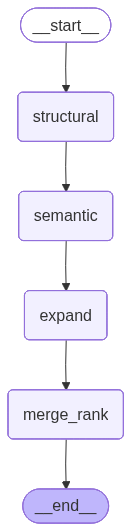

In [30]:
# ─── Cell 9: Graph Visualization ──────────────────────────────────────────────
# Tries LangGraph's built-in mermaid PNG first; falls back to matplotlib.

try:
    png_bytes = memory_recall_graph.get_graph().draw_mermaid_png()
    with open("memory_recall_graph.png", "wb") as f:
        f.write(png_bytes)
    print("LangGraph mermaid PNG saved to memory_recall_graph.png")
    display(Image(png_bytes))
except Exception as e1:
    print(f"Mermaid PNG failed ({type(e1).__name__}: {e1}), using matplotlib fallback...")

    import matplotlib
    matplotlib.use("Agg")  # non-interactive for script mode
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.patches import FancyArrowPatch

    BG    = "#1e1e2e"
    WHITE = "#cdd6f4"

    CLR_NODE = {
        "structural": "#89b4fa",
        "semantic":   "#a6e3a1",
        "expand":     "#fab387",
        "merge_rank": "#cba6f7",
    }
    CLR_MEM  = {
        "Session\nMemory":    "#a6e3a1",
        "Latent\nPersuasion": "#cba6f7",
        "Strategy\nMemory":   "#f9e2af",
        "Concession\nMemory": "#fab387",
    }
    CLR_EDGE = {
        "belongs_to":    "#89b4fa",
        "similar_to":    "#a6e3a1",
        "temporal_next": "#f38ba8",
        "derived_from":  "#f5c2e7",
        "has_attribute": "#fab387",
    }

    fig, axes = plt.subplots(1, 2, figsize=(18, 7),
                             gridspec_kw={"width_ratios": [1, 1.4]})
    fig.patch.set_facecolor(BG)

    # ── Left panel: LangGraph pipeline ──────────────────────────
    ax = axes[0]
    ax.set_facecolor(BG)
    ax.set_xlim(-0.5, 4.5); ax.set_ylim(-1, 6); ax.axis("off")
    ax.set_title("LangGraph Pipeline", color=WHITE, fontsize=12, pad=10)

    pipe_nodes = ["structural", "semantic", "expand", "merge_rank"]
    py_vals    = [4.5, 3.0, 1.5, 0.0]
    labels     = ["structural\nrecall", "semantic\nsession", "graph\nexpand", "merge\nrank"]
    edges_lg   = ["belongs_to", "similar_to", "temporal_next\n+ derived_from", ""]

    for name, yv, lbl, elbl in zip(pipe_nodes, py_vals, labels, edges_lg):
        c = mpatches.FancyBboxPatch((1.0, yv-0.4), 2.0, 0.8,
                                    boxstyle="round,pad=0.12",
                                    linewidth=2, edgecolor=WHITE,
                                    facecolor=CLR_NODE[name], zorder=3)
        ax.add_patch(c)
        ax.text(2.0, yv, lbl, ha="center", va="center",
                fontsize=9, fontweight="bold", color=BG, zorder=4)
        # edge label going downward
        if elbl:
            ax.text(3.4, yv-0.75, elbl, ha="center", va="center",
                    fontsize=6.5, color="#f5c2e7", fontstyle="italic", zorder=4)

    # Arrows between pipeline nodes
    for i in range(len(py_vals)-1):
        ax.annotate("", xy=(2.0, py_vals[i+1]+0.4), xytext=(2.0, py_vals[i]-0.4),
                    arrowprops=dict(arrowstyle="->", color=WHITE, lw=2), zorder=2)

    # START / END markers
    ax.text(2.0, 5.2, "▶  START", ha="center", va="center",
            fontsize=9, color="#a6e3a1", fontweight="bold")
    ax.annotate("", xy=(2.0, py_vals[0]+0.4), xytext=(2.0, 5.0),
                arrowprops=dict(arrowstyle="->", color="#a6e3a1", lw=1.5))
    ax.text(2.0, -0.75, "■  END", ha="center", va="center",
            fontsize=9, color="#cba6f7", fontweight="bold")

    # ── Right panel: Memory node graph ──────────────────────────
    ax2 = axes[1]
    ax2.set_facecolor(BG)
    ax2.set_xlim(-1, 11); ax2.set_ylim(-1, 9); ax2.axis("off")
    ax2.set_title("Memory Node Graph (per persona)", color=WHITE, fontsize=12, pad=10)

    # Persona hub
    persona_pos = (5, 7.5)
    hub = mpatches.Circle(persona_pos, 0.9, facecolor="#89dceb",
                          edgecolor=WHITE, linewidth=2, zorder=5)
    ax2.add_patch(hub)
    ax2.text(*persona_pos, "Persona A", ha="center", va="center",
             fontsize=9, fontweight="bold", color=BG, zorder=6)

    # Memory type positions (year rows: 2015, 2016, 2017)
    mem_types = list(CLR_MEM.keys())
    mem_xs    = [1.5, 3.5, 6.5, 9.0]
    years_show= [2015, 2016, 2017]
    year_ys   = [5.5, 3.5, 1.5]

    mem_pos: Dict = {}  # (mem_type_idx, year) → (x,y)
    for mi, (mt, mx) in enumerate(zip(mem_types, mem_xs)):
        for yi, (yr, yy) in enumerate(zip(years_show, year_ys)):
            pos = (mx, yy)
            mem_pos[(mi, yr)] = pos
            clr = list(CLR_MEM.values())[mi]
            c = mpatches.Circle(pos, 0.55, facecolor=clr,
                                edgecolor=WHITE, linewidth=1.5, zorder=4)
            ax2.add_patch(c)
            short = mt.split("\n")
            ax2.text(pos[0], pos[1]+0.1, short[0], ha="center", va="center",
                     fontsize=6.5, fontweight="bold", color=BG, zorder=5)
            ax2.text(pos[0], pos[1]-0.2, str(yr), ha="center", va="center",
                     fontsize=6, color=BG, zorder=5)

        # belongs_to arrow from persona to top row
        px, py = persona_pos
        tx, ty = mx, year_ys[0]
        ax2.annotate("", xy=(tx, ty+0.55), xytext=(px, py-0.9),
                     arrowprops=dict(arrowstyle="->",
                                     color=CLR_EDGE["belongs_to"], lw=1.2,
                                     connectionstyle="arc3,rad=0.1"), zorder=3)

    # Year axis label
    for yr, yy in zip(years_show, year_ys):
        ax2.text(-0.2, yy, str(yr), ha="center", va="center",
                 fontsize=8, color=WHITE, fontweight="bold")

    # temporal_next arrows (within same memory type, across years)
    for mi, mx in enumerate(mem_xs):
        for yi in range(len(years_show)-1):
            p1 = mem_pos[(mi, years_show[yi])]
            p2 = mem_pos[(mi, years_show[yi+1])]
            ax2.annotate("", xy=(p2[0], p2[1]+0.55), xytext=(p1[0], p1[1]-0.55),
                         arrowprops=dict(arrowstyle="->",
                                         color=CLR_EDGE["temporal_next"], lw=1.2))

    # derived_from: session(0) → latent(1) for first year
    p_sess  = mem_pos[(0, 2015)]
    p_latent= mem_pos[(1, 2015)]
    ax2.annotate("", xy=(p_latent[0]-0.55, p_latent[1]),
                 xytext=(p_sess[0]+0.55, p_sess[1]),
                 arrowprops=dict(arrowstyle="->",
                                 color=CLR_EDGE["derived_from"], lw=1.5,
                                 connectionstyle="arc3,rad=-0.3"))

    # similar_to: curved arrow from session 2015 back to session 2017
    p1 = mem_pos[(0, 2015)]
    p2 = mem_pos[(0, 2017)]
    ax2.annotate("", xy=(p2[0]-0.55, p2[1]),
                 xytext=(p1[0]-0.55, p1[1]),
                 arrowprops=dict(arrowstyle="<->",
                                 color=CLR_EDGE["similar_to"], lw=1.5,
                                 connectionstyle="arc3,rad=0.5"))
    ax2.text(-0.5, 3.5, "similar_to", ha="center", va="center",
             fontsize=6.5, color=CLR_EDGE["similar_to"], rotation=90)

    # Legend
    legend_items = [
        mpatches.Patch(color=v, label=k) for k, v in CLR_EDGE.items()
    ]
    ax2.legend(handles=legend_items, loc="lower right",
               ncol=3, fontsize=7.5, frameon=True,
               facecolor="#313244", edgecolor=WHITE, labelcolor=WHITE)

    plt.suptitle("Memory Recall Graph Architecture", color=WHITE, fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig("memory_recall_graph.png", dpi=150, bbox_inches="tight",
                facecolor=fig.get_facecolor())
    plt.show()
    print("Matplotlib graph saved to memory_recall_graph.png")

In [31]:
# ─── Cell 10: Test Run ────────────────────────────────────────────────────────
# Simulate an incoming conversation for persona P_001
# Query: price-sensitive (0.9) + low trust (0.3) user — classic negotiation pattern

test_query_vector = {
    "information_seeking": 0.6,
    "price_sensitivity":   0.9,   # high → should surface past price-haggle sessions
    "trust_level":         0.3,   # low trust
    "decision_readiness":  0.5,
    "emotional_valence":   0.4,
}

initial_state: MemoryState = {
    "persona_id":      "P_001",
    "current_year":    2018,
    "query_vector":    test_query_vector,
    "retrieved_nodes": [],
    "context":         "",
}

SEP = "═" * 68
print(SEP)
print(" MEMORY RECALL GRAPH — TEST RUN")
print(SEP)
print(f"  Persona      : {initial_state['persona_id']}")
print(f"  Current year : {initial_state['current_year']}")
print(f"  Query vector : {initial_state['query_vector']}")
print(SEP)

result = memory_recall_graph.invoke(initial_state)

print("\n" + SEP)
print(" FINAL RETRIEVED CONTEXT")
print(SEP)
print(result["context"])
print("\n" + SEP)
print(f"  Total nodes in context window : {len(result['retrieved_nodes'])}")
print(SEP)

════════════════════════════════════════════════════════════════════
 MEMORY RECALL GRAPH — TEST RUN
════════════════════════════════════════════════════════════════════
  Persona      : P_001
  Current year : 2018
  Query vector : {'information_seeking': 0.6, 'price_sensitivity': 0.9, 'trust_level': 0.3, 'decision_readiness': 0.5, 'emotional_valence': 0.4}
════════════════════════════════════════════════════════════════════

[structural_recall_node] ─── belongs_to edges ───
  [session]    year=2025, outcome=Reject, trust=0.420
  [latent]     trust=0.447, commitment=0.900, concession_exp=0.500
  [strategy]   Emotional: success_rate=0.705, uses=44, delta_readiness=1.8
  [strategy]   Logical: success_rate=0.804, uses=51, delta_readiness=4.5
  [strategy]   Credibility: success_rate=0.611, uses=36, delta_readiness=-1.7
  [concession] last_user_req=3500, last_agent_offer=3500, rounds=225

[semantic_session_node] ─── similar_to edges ───
  [similar_to] year=2015, cosine_sim=0.9902, outcome=R

In [32]:
# ─── Cell 11: Detailed Node Trace ─────────────────────────────────────────────
# Full inspection of every retrieved node with all data fields.

print("DETAILED NODE TRACE\n")
for i, node in enumerate(result["retrieved_nodes"], 1):
    print(f"{'─'*68}")
    print(f"  Node {i:>2} │ type={node['node_type'].upper():<10}"
          f" │ year={node['year']}"
          f" │ edge={node['edge']:<14}"
          f" │ score={node['score']:.4f}")
    print(f"  Data:")
    for k, v in node["data"].items():
        if isinstance(v, dict):
            print(f"    {k}:")
            for dk, dv in v.items():
                dv_str = f"{dv:.4f}" if isinstance(dv, float) else str(dv)
                print(f"      {dk}: {dv_str}")
        elif isinstance(v, float):
            print(f"    {k}: {v:.4f}")
        else:
            print(f"    {k}: {v}")
print(f"{'─'*68}")
print(f"\n  Summary: {len(result['retrieved_nodes'])} nodes retrieved,"
      f" edges used: { {n['edge'] for n in result['retrieved_nodes']} }")

DETAILED NODE TRACE

────────────────────────────────────────────────────────────────────
  Node  1 │ type=SESSION    │ year=2025 │ edge=belongs_to     │ score=1.0000
  Data:
    avg_intent_vector:
      information_seeking: 0.6967
      price_sensitivity: 0.7433
      trust_level: 0.4267
      decision_readiness: 0.2933
      emotional_valence: 0.4633
    avg_strategy_vector:
      credibility: 0.5571
      emotional_appeal: 0.5500
      logical_argument: 0.5357
      personalization: 0.6357
    final_outcome: Reject
    trust_estimate: 0.4200
    price_sensitivity: 0.7600
────────────────────────────────────────────────────────────────────
  Node  2 │ type=LATENT     │ year=2025 │ edge=belongs_to     │ score=1.0000
  Data:
    trust: 0.4469
    price_sensitivity: 0.7106
    commitment: 0.9000
    logical_resp: 0.6482
    emotional_resp: 0.6994
    credibility_resp: 0.3966
    concession_expectation: 0.5000
────────────────────────────────────────────────────────────────────
  Node  3